# EmojiPred 

### Loading glove embeddings

In [1]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
import pandas
import string
import pandas as pd
import collections
import itertools
import numpy as np
import pickle 
import nltk
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import random

In [4]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [5]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub

# Tensorflow GPU check
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2021-11-28 05:54:46.906523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 13440 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:03:00.0, compute capability: 6.1


True

### Parameters

In [6]:
embed_path = 'embeddings/twitter_27B_200d.kv'
embed_dim = 200
emb_model = KeyedVectors.load(embed_path)

# backtranslated data
lang='english'
data_path = 'data/twitter-kaggle/aug_train_clean.csv'
min_len = 2
max_len = 15
max_pad_len = 10
num_classes = 20

In [7]:
df = pd.read_csv(data_path)
df.head()

,tweet,label
0,vacation wasted vacation photobomb tired vacat...,0
1,oh wynwood youre so funny user wynwood art itw...,1
2,been friends since th grade look at us now we ...,2
3,this is what it looks like when someone loves ...,3
4,rt user this white family was invited to a bla...,3


In [8]:
print("Before:\n", df.isnull().sum())
df = df.dropna()
print("\nAfter:\n", df.isnull().sum())

Before:
 tweet    2
label    0
dtype: int64

After:
 tweet    0
label    0
dtype: int64


In [9]:
df['token'] = df['tweet'].apply(lambda x: x.split())
df['len'] = df['token'].apply(lambda x: len(x))
df.head()

,tweet,label,token,len
0,vacation wasted vacation photobomb tired vacat...,0,"[vacation, wasted, vacation, photobomb, tired,...",10
1,oh wynwood youre so funny user wynwood art itw...,1,"[oh, wynwood, youre, so, funny, user, wynwood,...",12
2,been friends since th grade look at us now we ...,2,"[been, friends, since, th, grade, look, at, us...",19
3,this is what it looks like when someone loves ...,3,"[this, is, what, it, looks, like, when, someon...",15
4,rt user this white family was invited to a bla...,3,"[rt, user, this, white, family, was, invited, ...",20


In [10]:
df['len'].value_counts()

10    7502
11    7262
9     7084
8     6620
12    6552
13    5787
7     5663
14    5007
6     4881
15    4303
5     3977
16    3707
4     2888
17    2816
18    2000
3     1722
19    1098
20     573
2      494
21     211
22     105
23      56
24      48
1       46
26      27
25      23
27      16
28      12
29       9
30       4
32       2
31       1
33       1
35       1
Name: len, dtype: int64

<AxesSubplot:xlabel='len', ylabel='count'>

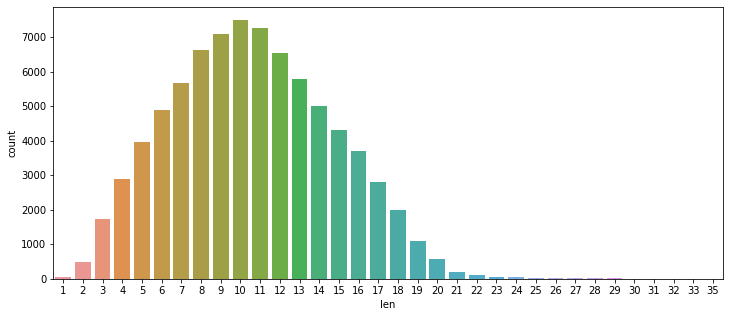

In [11]:
plt.figure(figsize=(12, 5))
sns.countplot(x=df['len'])

In [12]:
filter_idx = (df['len'] <= max_len)
df = df[filter_idx]
filter_idx = (df['len'] >= min_len)
df = df[filter_idx]
df.describe()

,label,len
count,69742.000000,69742.000000
mean,8.672808,9.558573
std,5.192914,3.261066
min,0.000000,2.000000
25%,3.000000,7.000000
50%,9.000000,10.000000
75%,13.000000,12.000000
max,19.000000,15.000000


In [14]:
# Universal Sentence Encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
univ_model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [15]:
df['sent'] = df['tweet'].progress_apply(lambda x: np.array(univ_model([x])).flatten())

  0%|          | 0/69742 [00:00<?, ?it/s]

In [17]:
def add_embeddings(data):
    
    emb_data = []
    for word in data:
        if word not in emb_model.key_to_index:
            pass
        else:
            word_emb = emb_model[word] 
            emb_data.append(word_emb)
        
    # check if padding / clipping required
    pad = False
    clip = False
    if len(emb_data) < max_pad_len:
        pad = True
    elif len(emb_data) > max_pad_len:
        clip = True
    else:
        pad = clip = False
        
    # padding
    if pad:
        deficiency = max_pad_len - len(emb_data)
        for pad in range(deficiency):
            emb_data.append(np.zeros(embed_dim))
            
    elif clip:
        # Taking last few tokens
        surplus = len(emb_data) - max_pad_len
        emb_data = emb_data[(-max_pad_len):]
      
    emb_data = np.array(emb_data, dtype=float)
    # print(emb_data.shape, emb_data.shape==(max_pad_len, embed_dim))
    
    return emb_data


In [18]:
df['emb_matrix'] = df['token'].progress_apply(add_embeddings)

  0%|          | 0/69742 [00:00<?, ?it/s]

In [19]:
df['emb_flatten'] = df['emb_matrix'].progress_apply(lambda x: x.flatten())

  0%|          | 0/69742 [00:00<?, ?it/s]

In [20]:
df.head()

,tweet,label,token,len,sent,emb_matrix,emb_flatten
0,vacation wasted vacation photobomb tired vacat...,0,"[vacation, wasted, vacation, photobomb, tired,...",10,"[-0.015930604, -0.0154482955, -0.023551408, 0....","[[0.09774699807167053, -0.10718999803066254, -...","[0.09774699807167053, -0.10718999803066254, -0..."
1,oh wynwood youre so funny user wynwood art itw...,1,"[oh, wynwood, youre, so, funny, user, wynwood,...",12,"[-0.010408631, 0.056681238, 0.06982707, -0.053...","[[-0.04025299847126007, 0.6596999764442444, 0....","[-0.04025299847126007, 0.6596999764442444, 0.3..."
3,this is what it looks like when someone loves ...,3,"[this, is, what, it, looks, like, when, someon...",15,"[0.036507826, 0.014146647, -0.04525541, 0.0352...","[[-0.015537000261247158, 0.1115799993276596, -...","[-0.015537000261247158, 0.1115799993276596, -0..."
5,track season im ready for ya university of the...,4,"[track, season, im, ready, for, ya, university...",11,"[0.030965062, -0.037396926, -0.007877281, 0.02...","[[0.07942599803209305, -0.011366000398993492, ...","[0.07942599803209305, -0.011366000398993492, 0..."
6,merry christmas you filthy little animals wear...,5,"[merry, christmas, you, filthy, little, animal...",13,"[-0.05320477, 0.028939093, -0.04028924, -0.030...","[[-0.09439200162887573, 0.0683009997010231, 0....","[-0.09439200162887573, 0.0683009997010231, 0.1..."


In [23]:
X_tok = np.array(list(df['emb_flatten'].to_numpy()))
print(X_tok.shape)
X_sent = np.array(list(df['sent'].to_numpy()))
print(X_sent.shape)

X = np.concatenate((X_tok, X_sent), axis=1)
y = df['label'].values
# y = to_categorical(y)
X.shape, y.shape

(69742, 2000)
(69742, 512)


((69742, 2512), (69742,))

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=4)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(66254, 2512) (3488, 2512) (66254, 20) (3488, 20)


In [69]:
# X = np.array(list(df['emb_matrix'].to_numpy()))
# y = df['label'].values
# y = to_categorical(y)
# X.shape, y.shape

### EmojiPred Architecture

In [70]:
X.shape, y.shape

((69742, 2512), (69742,))

In [71]:
from keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.layers import Input, Bidirectional, Embedding, Dense, Dropout, SpatialDropout1D, LSTM, Activation, GlobalMaxPool1D, Conv1D
from keras.regularizers import L1L2
from attention import AttentionWeightedAverage
import numpy as np
from copy import deepcopy
from os.path import exists
import h5py

In [72]:
def emoji_pred(input_dim, num_classes):
    # create model
    model_input = Input(shape=input_dim)
    
    token = model_input[:,:2000]
    print(token.shape)
    token = tf.reshape(token, [tf.shape(token)[0], 10,200])
    sent = model_input[:,-512:]
    print(token.shape, sent.shape)
    
    x = Activation('relu')(token)
    # x = Activation('relu')(token)
    print(x.shape)
    embed_drop = SpatialDropout1D(0.2, name='embed_drop')
    x = embed_drop(x)
    
    # token embeddings are 200, sentence embeddings = 2000
    lstm_0_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_0")(x)
    print(x.shape)
    lstm_1_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_1")(lstm_0_output)
    print(x.shape)
    x = concatenate([lstm_1_output, lstm_0_output, x])
    print(x.shape)
    x = GlobalMaxPool1D()(x)
    print(x.shape)
    # x = AttentionWeightedAverage(name='attlayer', return_attention=False)(x)
    
    # Concatenate sentence embeddings
    sent = Dense(200, activation='relu', name='FC-1')(sent)
    print(sent.shape)
    x = concatenate([x, sent])
    print(x.shape)
    outputs = [Dense(num_classes, activation='softmax', name='softmax')(x)]
    # print(outputs.shape)
    
    model = Model(inputs=[model_input], outputs=outputs, name="EmojiPred")
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [73]:
# Call model
mlp_model = emoji_pred((2512,), num_classes)
history = mlp_model.fit(X, to_categorical(y), validation_split=0.1, epochs=30, verbose=2)

# Predictions
y_pred_cat = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

# Accuracy
result = mlp_model.evaluate(X_test, y_test, verbose=0)
model_accuracy = result[1]
y_test = np.argmax(y_test, axis=1)
# model_precision = metrics.precision_score(y_test, y_pred, average='weighted')
# model_recall = metrics.recall_score(y_test, y_pred, average='weighted')
# model_f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f">>> Accuracy of model = {(100*model_accuracy):.4f} %\n")
print(classification_report(y_test, y_pred))

(None, 2000)
(None, 10, 200) (None, 512)
(None, 10, 200)
(None, 10, 200)
(None, 10, 200)
(None, 10, 1800)
(None, 1800)
(None, 200)
(None, 2000)
Epoch 1/30
2071/2071 - 28s - loss: 2.3679 - accuracy: 0.3053 - val_loss: 2.2443 - val_accuracy: 0.3417
Epoch 2/30
2071/2071 - 23s - loss: 2.2221 - accuracy: 0.3384 - val_loss: 2.2138 - val_accuracy: 0.3432
Epoch 3/30
2071/2071 - 23s - loss: 2.1511 - accuracy: 0.3534 - val_loss: 2.2150 - val_accuracy: 0.3369
Epoch 4/30
2071/2071 - 23s - loss: 2.0755 - accuracy: 0.3728 - val_loss: 2.2010 - val_accuracy: 0.3426
Epoch 5/30
2071/2071 - 23s - loss: 1.9805 - accuracy: 0.3971 - val_loss: 2.1798 - val_accuracy: 0.3552
Epoch 6/30
2071/2071 - 23s - loss: 1.8548 - accuracy: 0.4333 - val_loss: 2.2091 - val_accuracy: 0.3420
Epoch 7/30
2071/2071 - 23s - loss: 1.6996 - accuracy: 0.4726 - val_loss: 2.2398 - val_accuracy: 0.3535
Epoch 8/30
2071/2071 - 23s - loss: 1.5270 - accuracy: 0.5253 - val_loss: 2.2858 - val_accuracy: 0.3438
Epoch 9/30
2071/2071 - 23s - los

In [54]:
# Accuracy
result = mlp_model.evaluate(X_train, y_train, verbose=0)
model_accuracy = result[1]
print(model_accuracy)

0.9629491567611694


In [71]:
mlp_model.save('models/emoji_pred_use-4.h5')

## Top 5 accuracy
If any of model's top-5 predictions matches with the correct result, set 1



In [37]:
def top_5_acc(y_test, y_pred_cat):
    n = y_pred_cat.shape[0]
    plen = y_pred_cat.shape[1]
    top_5 = np.zeros(n)
    
    for i in range(n):
        true_val = y_test[i]
        pred_prob = y_pred_cat[i]
        pred_prob = [(pred_prob[j], j) for j in range(plen)]
        pred_prob = sorted(pred_prob)[::-1]
        pred_prob = pred_prob[:5]
        pred_labels = [k[1] for k in pred_prob]
        # print(pred_labels)
        if true_val in pred_labels:
            top_5[i] = 1
    
    return np.mean(top_5)*100

In [38]:
print(f"Top-5 accuracy of model = {top_5_acc(y_test, y_pred_cat):.4f}")

Top-5 accuracy of model = 67.4728


### Plot Acc and loss curves

Accuracy

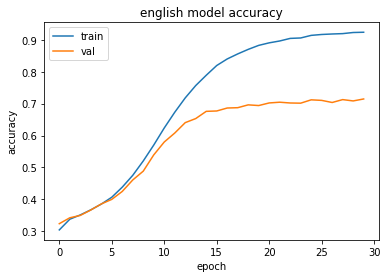

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(lang+' model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('assets/'+lang+'_acc.png', dpi=300)
plt.show()

Loss

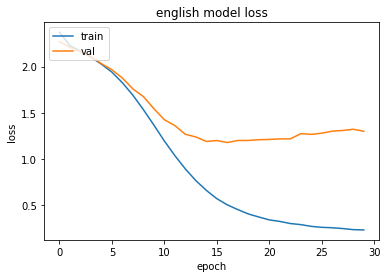

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(lang+' model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('assets/'+lang+'_loss.png', dpi=300)
plt.show()

### Causal Convolution

In [88]:
def emoji_pred_conv(input_dim, num_classes):
    # create model
    model_input = Input(shape=input_dim)
    x = Activation('relu')(model_input)
    print(x.shape)
    embed_drop = SpatialDropout1D(0.2, name='embed_drop')
    x = embed_drop(x)
    
    conv_1 = Conv1D(512, 3, dilation_rate = [1], padding='causal', activation='relu',name = 'conv_1')(x)
    print(x.shape)
    conv_2 = Conv1D(256, 3, dilation_rate = [2], padding='causal', activation = 'relu',name = 'conv_2')(conv_1)
    print(x.shape)
    conv_3 = Conv1D(128, 3, dilation_rate = [3], padding='causal', activation = 'relu',name = 'conv_3')(conv_2)
    print(x.shape)
    
    # # token embeddings are 200, sentence embeddings = 2000
    # lstm_0_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_0")(x)
    # print(x.shape)
    # lstm_1_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_1")(lstm_0_output)
    # print(x.shape)
    # x = concatenate([lstm_1_output, lstm_0_output, x])
    x = concatenate([conv_3, conv_2, conv_1, x])
    print(x.shape)
    x = GlobalMaxPool1D()(x)
    print(x.shape)
    # x = AttentionWeightedAverage(name='attlayer', return_attention=False)(x)
    outputs = [Dense(num_classes, activation='softmax', name='softmax')(x)]
    # print(outputs.shape)
    
    model = Model(inputs=[model_input], outputs=outputs, name="EmojiPredConv")
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [89]:
# Call model
mlp_model = emoji_pred_conv((10,200), num_classes)
history = mlp_model.fit(X, y, validation_split=0.1, epochs=100, verbose=2)

# Predictions
# y_pred_cat = mlp_model.predict(X)
# y_pred = np.argmax(y_pred_cat, axis=1)

# Accuracy
result = mlp_model.evaluate(X, y, verbose=0)
model_accuracy = result[1]
# y_test = np.argmax(y_test, axis=1)
# model_precision = metrics.precision_score(y_test, y_pred, average='weighted')
# model_recall = metrics.recall_score(y_test, y_pred, average='weighted')
# model_f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f">>> Accuracy of MLP model = {(100*model_accuracy):.4f} %\n")

(None, 10, 200)
(None, 10, 200)
(None, 10, 200)
(None, 10, 200)
(None, 10, 1096)
(None, 1096)
Epoch 1/100
1962/1962 - 13s - loss: 2.4596 - accuracy: 0.2830 - val_loss: 2.3376 - val_accuracy: 0.3072
Epoch 2/100
1962/1962 - 12s - loss: 2.3131 - accuracy: 0.3199 - val_loss: 2.2464 - val_accuracy: 0.3342
Epoch 3/100
1962/1962 - 12s - loss: 2.2375 - accuracy: 0.3381 - val_loss: 2.1949 - val_accuracy: 0.3459
Epoch 4/100
1962/1962 - 12s - loss: 2.1626 - accuracy: 0.3546 - val_loss: 2.1277 - val_accuracy: 0.3591
Epoch 5/100
1962/1962 - 12s - loss: 2.0821 - accuracy: 0.3714 - val_loss: 2.0782 - val_accuracy: 0.3732
Epoch 6/100
1962/1962 - 12s - loss: 1.9861 - accuracy: 0.3960 - val_loss: 2.0048 - val_accuracy: 0.3890
Epoch 7/100
1962/1962 - 12s - loss: 1.8893 - accuracy: 0.4193 - val_loss: 1.9704 - val_accuracy: 0.4043
Epoch 8/100
1962/1962 - 12s - loss: 1.7957 - accuracy: 0.4428 - val_loss: 1.9057 - val_accuracy: 0.4239
Epoch 9/100
1962/1962 - 12s - loss: 1.6988 - accuracy: 0.4721 - val_loss: 

KeyboardInterrupt: 

### Model

In [48]:
# Implement tensorflow model for classification

# define classification model
def classification_model(input_dim, num_classes):
    # create model
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [50]:
# Call model
mlp_model = classification_model(2000, num_classes)
history = mlp_model.fit(X, y, validation_split=0.1, epochs=1, verbose=2)

# Predictions
y_pred_cat = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

# Accuracy
result = mlp_model.evaluate(X, y, verbose=0)
model_accuracy = result[1]
# y_test = np.argmax(y_test, axis=1)
# model_precision = metrics.precision_score(y_test, y_pred, average='weighted')
# model_recall = metrics.recall_score(y_test, y_pred, average='weighted')
# model_f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f">>> Accuracy of MLP model = {(100*model_accuracy):.4f} %\n")

Epoch 1/10
1962/1962 - 6s - loss: 2.5144 - accuracy: 0.2721 - val_loss: 2.3404 - val_accuracy: 0.2979
Epoch 2/10
1962/1962 - 5s - loss: 2.3098 - accuracy: 0.3143 - val_loss: 2.2092 - val_accuracy: 0.3297
Epoch 3/10
1962/1962 - 5s - loss: 2.0977 - accuracy: 0.3616 - val_loss: 2.0612 - val_accuracy: 0.3708
Epoch 4/10
1962/1962 - 5s - loss: 1.8165 - accuracy: 0.4305 - val_loss: 1.9210 - val_accuracy: 0.4292
Epoch 5/10
1962/1962 - 5s - loss: 1.5087 - accuracy: 0.5156 - val_loss: 1.8275 - val_accuracy: 0.4748
Epoch 6/10
1962/1962 - 5s - loss: 1.2279 - accuracy: 0.6006 - val_loss: 1.7778 - val_accuracy: 0.5146
Epoch 7/10
1962/1962 - 5s - loss: 1.0094 - accuracy: 0.6692 - val_loss: 1.7947 - val_accuracy: 0.5406
Epoch 8/10
1962/1962 - 5s - loss: 0.8549 - accuracy: 0.7204 - val_loss: 1.8501 - val_accuracy: 0.5557
Epoch 9/10
1962/1962 - 5s - loss: 0.7362 - accuracy: 0.7608 - val_loss: 1.8747 - val_accuracy: 0.5712
Epoch 10/10
1962/1962 - 5s - loss: 0.6428 - accuracy: 0.7893 - val_loss: 1.9395 - 